#HOG + PCA + NN + SVM

In [1]:
import tensorflow as tf
DEVICES=tf.config.experimental.list_physical_devices()
tf.config.experimental.set_memory_growth(device=DEVICES[1],enable=True)
print('GPU Availability : ',tf.test.is_gpu_available())

GPU Availability :  True


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#Resnet-50 PCA
import os
import cv2
import glob
import h5py
import imutils
import argparse
import numpy as np 
import seaborn as sns
from pathlib import Path
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential    
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten,Input,InputLayer

In [4]:
from skimage.feature import hog
from skimage import exposure,util,feature 
from sklearn.utils import Bunch
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import svm, metrics, datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
def pcaimg(image):
    blue, green, red = cv2.split(image)
    df_red = red/255
    df_blue = blue/255
    df_green = green/255
    pca_b = PCA(n_components=50)
    pca_b.fit(df_blue)
    trans_pca_b = pca_b.transform(df_blue)
    
    pca_g = PCA(n_components=50)
    pca_g.fit(df_green)
    trans_pca_g = pca_g.transform(df_green)
    
    pca_r = PCA(n_components=50)
    pca_r.fit(df_red)
    trans_pca_r = pca_r.transform(df_red)    
    
    b_arr = pca_b.inverse_transform(trans_pca_b)
    g_arr = pca_g.inverse_transform(trans_pca_g)
    r_arr = pca_r.inverse_transform(trans_pca_r)
    
    img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))
    
    return img_reduced

In [6]:
def HOG(imagePath,size):
    H=[]
    image = cv2.imread(imagePath)
    imagem = cv2.bitwise_not(image)
    imS = cv2.resize(image, (size, size))
    gray = cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.3, tileGridSize=(8,8))
    img = clahe.apply(gray) 
    #gray = cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY)
    (H, hogImage) = hog(img, orientations=9, pixels_per_cell=(17, 17),cells_per_block=(2,2), transform_sqrt=True, block_norm="L1", visualize=True) 
    #Data Normalisation (Normalising HOG Features)
    H*=10
    return H

In [ ]:
SIZE = 256
data = []
labels = []
traindir='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/'#Enter the Train Directory
for directory_path in glob.glob(traindir+"/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        #print(img_path)
        A = HOG(img_path,SIZE)
        #H*=10 #data Normalisation
        data.append(A)
        labels.append(label)
np.save('./HOG_NN/data.npy',data)
np.save('./HOG_NN/labels.npy',labels)

In [7]:
data=np.load('./HOG_NN/data.npy')
labels=np.load('./HOG_NN/labels.npy')
#Data Normalisation (Normalising HOG Features)
#data=np.array(data)*10
# partition the data into training and testing 
(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.2,random_state=100)                                                                                                                 
train_labels= trainY 
test_labels= testY
#encode the labels (which are currently strings) as integers and then one-hot encode them
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(trainY)
train_onehot= le.transform(trainY)
le.fit(testY)
test_onehot= le.transform(testY)
#One hot encode y values for neural network.
from tensorflow.keras.utils import to_categorical
#labels = to_categorical(labels)
#One hot encode y values for neural network. Not needed for Random Forest
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [10]:
print(
trainX.shape,'\n',
testX.shape,'\n',
trainY.shape,'\n',
testY.shape,'\n',
y_train.shape,'\n',
y_test.shape,'\n'
)

(13151, 7056) 
 (3288, 7056) 
 (13151,) 
 (3288,) 
 (13151, 6719) 
 (3288, 6719) 



In [ ]:
from collections import Counter
print(*Counter(labels))

In [8]:
data=np.load('./HOG_NN/data.npy')
labels=np.load('./HOG_NN/labels.npy')
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
le.fit(labels)
toh= le.transform(labels)
train_Y=to_categorical(toh)
print(len(toh))
print(toh.shape)

16439
(16439, 1096)


Text(0, 0.5, 'Cum variance')

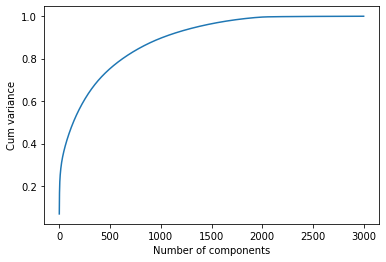

In [18]:
from sklearn.decomposition import PCA
# First verfiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=3000) 
#pca_test.fit(trainX)
pca_test.fit(data)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [9]:
#Pick the optimal number of components. This is how many features we will have 
#for our machine learning

n_PCA_components = 1000
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(data)
test_PCA = pca.transform(data) #Make sure you are just transforming, not fitting.

#If we want 90% information captured we can also try ...
#pca=PCA(0.9)
#principalComponents = pca.fit_transform(trainX)
#print(principalComponents.shape)

In [10]:
model = Sequential()
model.add(InputLayer(input_shape=(n_PCA_components,)))
model.add(Dense(1008,activation='relu'))
model.add(Dense(1008,activation='sigmoid'))
model.add(Dense(1008,activation='sigmoid'))
#model.add(Dense(1008,activation='relu'))
model.add(Dense(1096, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.load_weights('./HOG_NN/HOGNN_Muzzlepatterns.h5')

In [34]:
model.pop()
model.add(Dense(1100, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))
model.summary()

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./models/vrindhavan_model_weights.h5", 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto', 
                             #save_freq=1
                             )

early = EarlyStopping(monitor='categorical_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')
Adam(
    learning_rate=0.001,
    beta_1=0.16,
    beta_2=0.099,
    epsilon=3e-04,
    amsgrad=True,
    name="Adam",
    
)
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(train_PCA,toh, 
          epochs=10, 
          verbose=1,
          callbacks=[checkpoint]
          )

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

ValueError: You are passing a target array of shape (16439, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [32]:
model.save('./HOG_NN/HOGNN_Muzzlepatterns.h5')

In [37]:
##Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)

ValueError: y contains previously unseen labels: [1072 1073 1352 1353 1463 1464 1466 1470 1471 1473 1476 2181 2373 3145
 3147 3150 3151 3152 3153 3315 3319 3329 3331 3335 3336 3339 3342 3351
 3354 3357 3360 3363 3364 3365 3367 3380 3381 3384 3390 3391 3392 3396
 3400 3403 3408 3411 3413 3417 3418 3423 3424 3426 3428 3431 3432 3436
 3438 3439 3441 3443 3444 3447 3450 3451 3455 3464 3471 3472 3474 3475
 3477 3478 3480 3481 3483 3487 3491 3505 3511 3513 3515 3516 3531 3534
 3541 3543 3550 3551 3553 3556 3560 3563 3573 3575 3579 3582 3587 3589
 3590 3591 3595 3598 3602 3603 3607 3609 3612 3613 3619 3626 3629 3630
 3632 3636 3637 3638 3643 3645 3647 3648 3659 3662 3665 3669 3671 3674
 3675 3676 3682 3684 3687 3688 3690 3692 3697 3698 3700 3702 3705 3709
 3710 3711 3712 3717 3718 3722 3726 3727 3728 3731 3734 3735 3736 3737
 3748 3752 3753 3756 3757 3761 3763 3766 3767 3771 3773 3774 3775 3777
 3778 3779 3783 3789 3794 3798 3803 3805 3811 3814 3816 3817 3818 3819
 3820 3824 3826 3834 3836 3842 3843 3844 3846 3847 3850 3856 3858 3861
 3864 3865 3868 3870 3871 3875 3876 3878 3883 3888 3889 3893 3899 3900
 3901 3910 3912 3913 3915 3916 3917 3919 3920 3922 3925 3926 3927 3930
 3931 3932 3935 3937 3943 3944 3948 3953 3957 3961 3963 3966 3971 3972
 3973 3975 3978 3979 3982 3985 3990 3992 3994 3995 3997 3999 4013 4878
 4879 5022 5031 5037 5058 5065 5066 5082 5089 5091 5094 5095 5096 5111
 5120 5121 5122 5127 5128 5133 5134 5157 5158 5162 5163 5164 5165 5183
 5185 5187 5189 5191 5199 5200 5201 5216 5217 5219 5220 5223 5225 5227
 5231 5236 5251 5252 5258 5259 5262 5269 5270 5272 5273 5288 5290 5296
 5301 5303 5306 5311 5313 5316 5318 5320 5360 5377 5378 5379 5702 5857
 5858 5859 5861 5864 5866 5867 5868 5869 5871 5873 5877 5885 5887 5888
 5889 5891 5892 5894 5895 5898 5899 5901 5908 5909 5910 5913 5914 6039
 6055 6112 6138 6162 6165 6168 6170 6171 6180 6184 6256 6260 6267 6268
 6269 6271 6272 6287 6289 6290 6291 6292 6294 6296 6297 6299 6300 6304
 6306 6309 6323 6324 6329 6330 6331 6334 6335 6336 6338 6340 6345 6346
 6351 6352 6355 6359 6360 6363 6365 6384 6385 6388 6392 6401 6403 6404
 6406 6409 6411 6413 6418 6429 6433 6434 6436 6438 6439 6440 6441 6443
 6446 6452 6454 6456 6457 6460 6464 6465 6468 6473 6488 6489 6490 6491
 6492 6494 6498 6500 6501 6502 6503 6513 6514 6515 6516 6517 6519 6522
 6524 6527 6528 6529 6530 6531 6535 6536 6540 6541 6542 6544 6546 6548
 6553 6554 6562 6563 6566 6572 6586 6587 6590 6596 6597 6616 6618 6619
 6621 6622 6624 6627 6636 6637 6638 6640 6647 6648 6649 6650 6652 6653
 6654 6656 6661 6690 6699 6700 6703 6705]

In [38]:
test_PCA.shape

(3288, 1000)

In [39]:
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test))

Accuracy =  0.0


c:\Users\balaj\anaconda3\envs\GPU_ML\lib\site-packages\sklearn\metrics\_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
#testY=str(testY)
cm = confusion_matrix(test_labels, predict_test)
#print(cm)
sns.heatmap(cm, annot=True)

____0.bead black____
____1.bead_flat____
____2.bead colored____
____3.flat____
____4.flat_color____
____5.Valley____
____6.valley colored____
____7.bead valley____

In [ ]:
#Check results on a few select images
n=np.random.randint(0,testX.shape[0])
print(n)
val = testX[n]
print(val.shape)
x = np.expand_dims(val, axis=0) #Expand dims so the input is (num images, x, y, c)
print(x.shape)
# #Expand dims so the input is (num images, x, y, c)
input_img_feature=x
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", test_labels[n])

In [ ]:
imagepath='./path/Dataset/Group_Testing/237/admingaushala_Cow_Female_8.png'
H=HOG(imagepath,SIZE)
x = np.expand_dims(H, axis=0)
input_img_feature=X
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
#print("The actual label for this image is: ", test_labels[n])